In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json

### Load coco annotations

In [3]:
f = open('coco/annotations/instances_train2017.json')
anno = json.load(f)
f.close()

In [4]:
for i in anno:
    print(i, len(anno[i]))

info 6
licenses 8
images 118287
annotations 860001
categories 80


### Generate training data

In [5]:
data = {}
for item in anno['annotations']:
    if item['image_id'] not in data:
        data[item['image_id']] = [item['category_id']]
    else:
        data[item['image_id']].append(item['category_id'])
        
cat2ind = {}
ind2str = {}
i = 0
for item in anno['categories']:
    cat2ind[item['id']] = i
    ind2str[i] = item['name']
    i += 1

In [6]:
X_train = np.zeros([860001, 80])
Y_train = np.zeros([860001, 80])
start = 0
for img in data:
    step = len(data[img])
    for i in range(start, start+step):
        X_train[i, cat2ind[data[img][i-start]]] = 1
        Y_train[start:start+step, cat2ind[data[img][i-start]]] = 1
    start += step

print(X_train.shape)

(860001, 80)


### Simple neural layer

In [7]:
def add_layer(inputs, in_size, out_size, activ=None):
    W = tf.Variable(tf.random_normal([in_size, out_size]), name="W")
    b = tf.Variable(tf.zeros([1, out_size]), name="b")
    output = tf.matmul(inputs, W) + b
    if activ:
        output = activ(output)
    return output

### Training

In [8]:
xs = tf.placeholder(tf.float32, [None, 80], name="x_input")
ys = tf.placeholder(tf.float32, [None, 80], name="y_input")

# Build the simple word2vec network
hidd = add_layer(xs, 80, 1000, activ=tf.nn.relu)
pred = add_layer(hidd, 1000, 80)

# Loss and optimizer
loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys-pred), axis=[1]))
adam = tf.train.AdamOptimizer(1e-2)
train = adam.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(1000):
    batch = np.random.choice(860001, 5000, replace=False)
    sess.run(train, feed_dict = {xs: X_train[batch,:], ys: Y_train[batch,:]})
    if not i%100:
        print(sess.run(loss, feed_dict = {xs: X_train, ys: Y_train}))

28438.19
2.9340858
2.372924
2.3737762
2.374524
2.3760488
2.377306
2.3785121
2.3789127
2.381948


### Testing

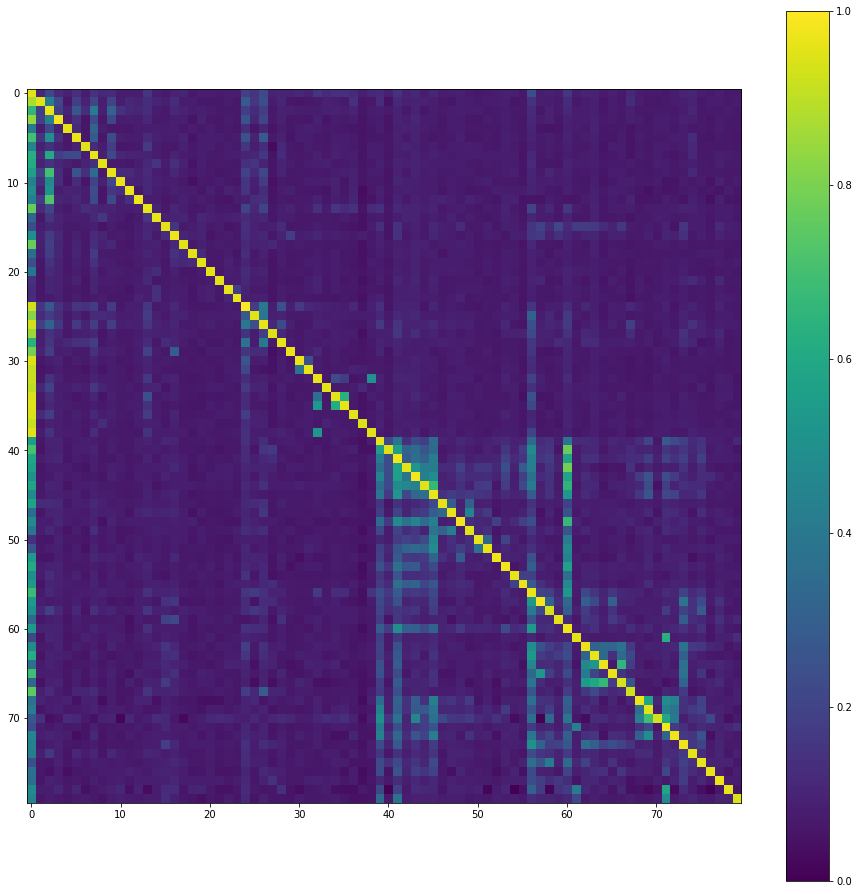

In [9]:
X_test = np.zeros([80, 80])
np.fill_diagonal(X_test, 1)
res = sess.run(pred, feed_dict = {xs: X_test})
nor_res = (res - np.min(res)) / (np.max(res) - np.min(res))
plt.figure(figsize = (16,16))
plt.imshow(nor_res)
plt.colorbar()

### Details

In [12]:
n = 9
for i in range(80):
    related = []
    for j in nor_res[i,:].argsort()[-n:][::-1]:
        related.append(ind2str[j])
    print(ind2str[i])
    print(related[1:])
    print()

person
['chair', 'handbag', 'car', 'backpack', 'dining table', 'bench', 'umbrella', 'sports ball']

bicycle
['person', 'car', 'backpack', 'handbag', 'motorcycle', 'truck', 'traffic light', 'bus']

car
['person', 'truck', 'traffic light', 'bus', 'motorcycle', 'backpack', 'handbag', 'bicycle']

motorcycle
['person', 'car', 'backpack', 'truck', 'traffic light', 'handbag', 'bicycle', 'bus']

airplane
['person', 'truck', 'car', 'backpack', 'bus', 'handbag', 'chair', 'laptop']

bus
['person', 'car', 'truck', 'handbag', 'backpack', 'traffic light', 'bicycle', 'motorcycle']

train
['person', 'traffic light', 'bench', 'backpack', 'car', 'handbag', 'truck', 'clock']

truck
['person', 'car', 'airplane', 'traffic light', 'bus', 'motorcycle', 'handbag', 'bicycle']

boat
['person', 'bird', 'umbrella', 'car', 'backpack', 'dog', 'truck', 'chair']

traffic light
['car', 'person', 'truck', 'bus', 'handbag', 'backpack', 'bicycle', 'train']

fire hydrant
['car', 'person', 'traffic light', 'truck', 'handba